Library

In [2]:
import string
import re
from collections import OrderedDict, Counter
from tabulate import tabulate
import pandas as pd
import nltk
import os
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')
nltk.data.path.append(nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to c:\Users\rovan
[nltk_data]     wardana\OneDrive\Dokumen\uts-ppdm\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to c:\Users\rovan
[nltk_data]     wardana\OneDrive\Dokumen\uts-ppdm\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\rovan
[nltk_data]     wardana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Gabungkan Stopword dari NLTK dan Sastrawi

In [3]:
# Gabungkan stopwords dari NLTK dan Sastrawi
indo_stopwords = set(stopwords.words('indonesian'))
sastrawi_stopwords = StopWordRemoverFactory().get_stop_words()
all_stopwords = list(indo_stopwords.union(sastrawi_stopwords))

Stopword Khusus Untuk Berita

In [4]:
additional_news_stopwords = ["advertisement", "scroll", "continue", "content", "gambasvideo", "detik"]
all_stopwords.extend(additional_news_stopwords)

Membaca Dataset dan Mengambil 20 Berita Saja

In [5]:
df = pd.read_csv("news_data.csv")
df = df[['article_text']].dropna().head(20)
text = [[f"Doc {i+1}", row['article_text']] for i, row in df.iterrows()]

In [6]:
stemfactory = StemmerFactory()
stemmer = stemfactory.create_stemmer()

whitelist = {"pemilu", "kpu", "pilpres", "prabowo", "ganjar", "gibran", "debate", "tps"}

# Stemming khusus
def custom_stem(text):
    return ' '.join([
        word if word in whitelist else stemmer.stem(word)
        for word in text.split()
    ])


Preprocessing

In [7]:
def preprocess_text(text):
    title, content = text
    
    # Clean the content - lebih komprehensif
    clean = content.lower()
    clean = re.sub(r'http\S+|www\S+|https\S+', '', clean)  # Hapus URL
    clean = re.sub(r'@\w+|#\w+', '', clean)  # Hapus mention dan hashtag
    clean = re.sub(r'\d+', '', clean)  # Hapus angka
    clean = "".join([c if c not in string.punctuation else ' ' for c in clean])  # Ganti tanda baca dengan spasi
    clean = re.sub(r'\s+', ' ', clean).strip()  # Hapus spasi berlebih
    
    # Tokenisasi dengan NLTK untuk hasil yang lebih baik
    tokens = word_tokenize(clean)
    
    # Stopword removal dengan gabungan stopwords
    filtered = [word for word in tokens if word not in all_stopwords and len(word) > 2]
    
    # Stemming
    # Stemming dengan whitelist
    stemmed = [word if word in whitelist else stemmer.stem(word) for word in filtered]

    # Terms - simpan frekuensi kata juga
    term_freq = Counter(stemmed)
    terms = list(term_freq.keys())
    
    return [title, clean, tokens, filtered, stemmed, terms, term_freq]

In [8]:
headers = ["Title", "Clean", "Tokens", "Filtered", "Stemmed", "Terms", "Term Frequency"]

semua_hasil = []
for idx, doc in enumerate(text):
    try:
        hasil = preprocess_text(doc)
        if len(hasil) != len(headers):
            print(f"Warning: Length mismatch for document {idx+1}. Expected {len(headers)}, got {len(hasil)}")
        semua_hasil.append(hasil)
        print(f"Document {idx+1}:")
        print(tabulate([hasil[:-1]], headers=headers[:-1], tablefmt="grid"))  # Exclude term frequency for display
        print('=' * 100)
        print("\n")
    except Exception as e:
        print(f"Error processing document {idx+1}: {e}")

hasil_df = pd.DataFrame(semua_hasil, columns=headers)

Document 1:
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Data Frame stemmed_text

In [9]:
df["stemmed_text"] = df["article_text"].apply(custom_stem)

In [10]:
term_frequencies = hasil_df['Term Frequency'].tolist()
hasil_df = hasil_df.drop('Term Frequency', axis=1)
hasil_df.to_csv("preprocessed_news_data.csv", index=False)
hasil_df['Stemmed_Text'] = hasil_df['Stemmed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=2,          # Abaikan terms yang muncul di kurang dari 2 dokumen
    max_df=0.9,        # Abaikan terms yang muncul di lebih dari 90% dokumen
    ngram_range=(1, 2), # Unigram dan bigram
    sublinear_tf=True   # Skala logaritmik untuk term frequency (1+log(tf))
)

X = vectorizer.fit_transform(hasil_df['Stemmed_Text'])

feature_names = vectorizer.get_feature_names_out()


Menentukan jumlah cluster optimal dengan metode Elbow

range_n_clusters: [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_scores: [np.float64(0.06191375149832248), np.float64(0.06943486524998105), np.float64(0.10215164326637405), np.float64(0.11631332869556721), np.float64(0.12266817060306912), np.float64(0.16831423076286803), np.float64(0.16707013879783103), np.float64(0.19394316579463733)]


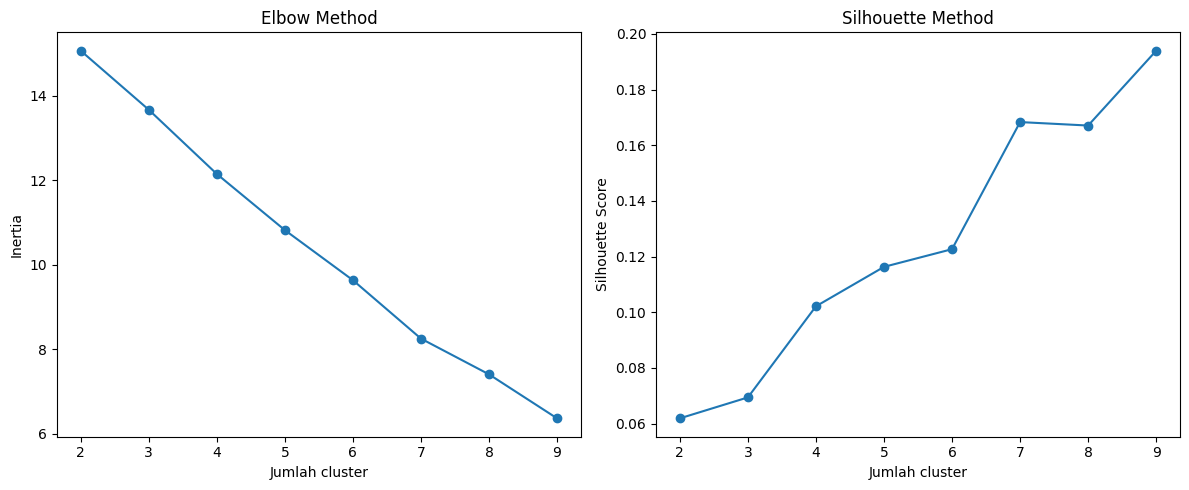

Jumlah cluster optimal berdasarkan silhouette score: 9


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Asumsikan X sudah didefinisikan sebagai TF-IDF matrix dan len(hasil_df) diketahui

if len(hasil_df) > 10:
    inertia = []
    silhouette_scores = []
    range_n_clusters = range(2, min(10, len(hasil_df)))
    
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
        # Hitung Silhouette Score untuk setiap n_clusters
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Debug print untuk memastikan panjang list sama
    print("range_n_clusters:", list(range_n_clusters))
    print("silhouette_scores:", silhouette_scores)
    
    # Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(list(range_n_clusters), inertia, 'o-')
    plt.xlabel('Jumlah cluster')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    
    plt.subplot(1, 2, 2)
    plt.plot(list(range_n_clusters), silhouette_scores, 'o-')
    plt.xlabel('Jumlah cluster')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    
    plt.tight_layout()
    plt.savefig('cluster_evaluation.png')
    plt.show()
    plt.close()
    
    # Tentukan jumlah cluster optimal berdasarkan silhouette score
    best_n_clusters = range_n_clusters[list(silhouette_scores).index(max(silhouette_scores))]
    print(f"Jumlah cluster optimal berdasarkan silhouette score: {best_n_clusters}")


CLUSTERING

In [13]:
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
hasil_df['cluster'] = cluster_labels

In [14]:
# Ekstraksi top terms untuk setiap cluster untuk interpretasi
def get_top_terms_per_cluster(vectorizer, kmeans, n_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    cluster_terms = {}
    for i in range(kmeans.n_clusters):
        top_term_indices = order_centroids[i, :n_terms]
        top_terms = [terms[idx] for idx in top_term_indices]
        cluster_terms[i] = top_terms
    
    return cluster_terms

In [15]:
top_terms = get_top_terms_per_cluster(vectorizer, kmeans)

# Print top terms untuk setiap cluster
print("\nTop terms per cluster:")
for cluster_id, terms in top_terms.items():
    print(f"Cluster {cluster_id}: {', '.join(terms)}")

# Simpan hasil clustering
hasil_df.to_csv("clustered_news_data.csv", index=False)


Top terms per cluster:
Cluster 0: kpps, anggota kpps, kpps pemilu, calon anggota, anggota, daftar calon, surat, syarat, daftar, surat daftar
Cluster 1: said, aqil, said aqil, gibran, pbnu said, pbnu, ponpes, pesantren, mantan ketua, siradj
Cluster 2: ganjar, mahfud, ganjar mahfud, debat, tpn, hasto, rakyat, pranowo mahfud, pranowo, ganjar pranowo
Cluster 3: aman, personel, tps, potensi, masyarakat, wilayah, rawan, pemilu, sumatera, jaga
Cluster 4: hadap, kuasa, prabowo, presiden, pilih presiden, pilih, februari, kali, gibran, aku
Cluster 5: pakar, panelis, debat, ilmu, tata, panelis debat, nama panelis, hukum, perdana, debat perdana
Cluster 6: hadir, tkn, prabowo, kampanye, menteri, acara, doa, tni, padang, beliau
Cluster 7: gerindra, dukung, prabowo, usung, dardak, emil, kader, penuh, partai, urus
Cluster 8: parpol, lapor, situs, ktp, anggota, langkah, daftar, partai politik, daftar anggota, tanggap


In [16]:
# Hitung distribusi dokumen per cluster
cluster_distribution = hasil_df['cluster'].value_counts().sort_index()
print("\nDistribusi dokumen per cluster:")
print(cluster_distribution)


Distribusi dokumen per cluster:
cluster
0    2
1    3
2    3
3    3
4    3
5    2
6    2
7    1
8    1
Name: count, dtype: int64


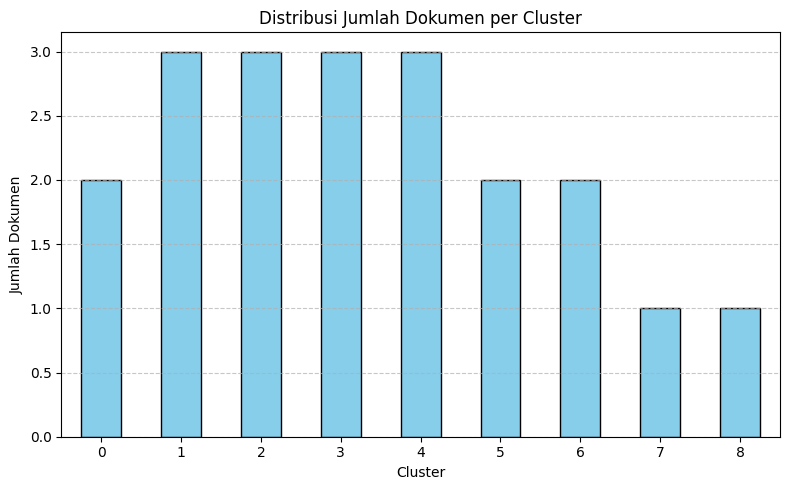

In [19]:
# Visualisasi distribusi dokumen per cluster
def plot_cluster_distribution(cluster_distribution):
    """
    Membuat grafik distribusi jumlah dokumen per cluster.

    Parameters:
    cluster_distribution (pandas.Series): Series yang berisi jumlah dokumen per cluster.
    """
    plt.figure(figsize=(8, 5))
    cluster_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel('Jumlah Dokumen')
    plt.title('Distribusi Jumlah Dokumen per Cluster')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('cluster_distribution.png')  # Simpan grafik sebagai file
    plt.show()  # Tampilkan grafik

# Panggil fungsi untuk menampilkan grafik distribusi
plot_cluster_distribution(cluster_distribution)


In [17]:
# Cetak hasil clustering
print("\nHasil Clustering:")
print(hasil_df[['Title', 'cluster']])


Hasil Clustering:
     Title  cluster
0    Doc 1        2
1    Doc 2        1
2    Doc 3        0
3    Doc 4        3
4    Doc 5        4
5    Doc 6        6
6    Doc 7        1
7    Doc 8        2
8    Doc 9        6
9   Doc 10        4
10  Doc 11        0
11  Doc 12        2
12  Doc 13        7
13  Doc 14        3
14  Doc 15        1
15  Doc 16        5
16  Doc 17        5
17  Doc 18        4
18  Doc 19        8
19  Doc 20        3
